In [4]:
from keras.models import load_model
model = load_model("CNN_vgg16.keras")

c:\Users\igrac\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\igrac\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 62 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [5]:
# obtain the dataset again
import os
import numpy as np
import pandas as pd

from const import *
from data_io import get_poster, plot_poster
from sklearn.model_selection import train_test_split

from tensorflow.keras import Input, Model, datasets
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# read encode dataframe and select only 3 genres
encoded_genre_df = pd.read_csv('encoded_genres.csv', index_col=0)
encoded_genre_df = encoded_genre_df[['_Action', '_Romance', '_Thriller']]
genre_count = np.sum(encoded_genre_df * 1, axis=1)
encoded_filtered = encoded_genre_df.loc[genre_count == 1]

# consider only movies released in year 2000-2024
valid_movies = encoded_genre_df.index
movie_year = pd.read_csv('data/movies.csv', index_col=0)
movie_year = movie_year['date']
mov = []
for i in valid_movies:
    mov.append(movie_year.iloc[i-1000001])
movie_year = pd.DataFrame(mov)
movie_year.index = valid_movies
movie_year = movie_year.loc[genre_count == 1]

encoded_filtered = encoded_filtered.loc[(movie_year.iloc[:,0] >= 2000) & (movie_year.iloc[:,0] <= 2024)]
print(encoded_filtered.head())
country=pd.read_csv('data/countries.csv', index_col=0)

df= encoded_filtered.merge(country, left_index=True, right_index=True)




          _Action  _Romance  _Thriller
movie_id                              
1000002     False     False       True
1000003      True     False      False
1000006     False     False       True
1000007      True     False      False
1000009     False      True      False


In [6]:
def performance_metrics(y_test,predy):
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from tensorflow.keras.metrics import AUC  

    from tensorflow.keras.ops import softmax
    from sklearn.metrics import roc_curve, auc, f1_score 
    import matplotlib.pyplot as plt


    predy_class = np.argmax(predy, axis=1)
    truey_class = np.argmax(y_test, axis=1)

    
    confusion_matrix = confusion_matrix(truey_class, predy_class)
    accuracy = accuracy_score(truey_class, predy_class)
    precision = precision_score(truey_class, predy_class, average='macro')
    recall = recall_score(truey_class, predy_class, average='macro')
    f1 = f1_score(truey_class, predy_class, average='macro')
    print(f'Confusion Matrix: \n{confusion_matrix}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')

    tf_auc = AUC(num_thresholds = 200, from_logits = True, multi_label = True)
    tf_auc.update_state(y_test, predy)
    AUC= tf_auc.result().numpy()
    print(f'AUC: {AUC}')
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # feed predy into softmax function for actual probabilities
    probi_y = softmax(predy, axis=-1)
    for i in range(n_genre):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], probi_y[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_genre):
        plt.plot(fpr[i], tpr[i], label = 'ROC curve of class {0} (area = {1:0.2f})'
                                        ''.format(i, roc_auc[i]))
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = 'lower right')
    plt.show    
    plt.savefig('ROC.png', dpi=300)

    

    return None


In [ ]:
#HK for sample

HongKong_df = df[df['country'] == 'Hong Kong']
HongKong_df = HongKong_df.drop(columns=['country'])
print(HongKong_df.head())

movie = []
encode = []
n_genre = HongKong_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,HongKong_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = HongKong_df.loc[HongKong_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_HK = np.array(movie)
encode_HK = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_HK = model.predict(movie_HK)
predy_class_HK = np.argmax(predy_HK, axis=1)
truey_class_HK = np.argmax(encode_HK, axis=1)

performance_metrics(encode_HK, predy_HK)



In [4]:
#mapping to continent
country_to_continent = {
    'Afghanistan': 'Asia',
    'Albania': 'Europe',
    'Algeria': 'Africa',
    'American Samoa': 'Oceania',
    'Andorra': 'Europe',
    'Angola': 'Africa',
    'Anguilla': 'North America',
    'Antarctica': 'Antarctica',
    'Antigua and Barbuda': 'North America',
    'Argentina': 'South America',
    'Armenia': 'Asia',
    'Aruba': 'North America',
    'Australia': 'Oceania',
    'Austria': 'Europe',
    'Azerbaijan': 'Asia',
    'Bahamas': 'North America',
    'Bahrain': 'Asia',
    'Bangladesh': 'Asia',
    'Barbados': 'North America',
    'Belarus': 'Europe',
    'Belgium': 'Europe',
    'Belize': 'North America',
    'Benin': 'Africa',
    'Bermuda': 'North America',
    'Bhutan': 'Asia',
    'Bolivarian Republic of Venezuela': 'South America',
    'Bolivia': 'South America',
    'Bosnia and Herzegovina': 'Europe',
    'Botswana': 'Africa',
    'Bouvet Island': 'Antarctica',
    'Brazil': 'South America',
    'British Indian Ocean Territory': 'Asia',
    'British Virgin Islands': 'North America',
    'Brunei Darussalam': 'Asia',
    'Bulgaria': 'Europe',
    'Burkina Faso': 'Africa',
    'Burundi': 'Africa',
    'Cambodia': 'Asia',
    'Cameroon': 'Africa',
    'Canada': 'North America',
    'Cape Verde': 'Africa',
    'Cayman Islands': 'North America',
    'Central African Republic': 'Africa',
    'Chad': 'Africa',
    'Chile': 'South America',
    'China': 'Asia',
    'Christmas Island': 'Asia',
    'Cocos (Keeling) Islands': 'Asia',
    'Colombia': 'South America',
    'Comoros': 'Africa',
    'Congo': 'Africa',
    'Cook Islands': 'Oceania',
    'Costa Rica': 'North America',
    'Croatia': 'Europe',
    'Cuba': 'North America',
    'Cyprus': 'Europe',
    'Czechia': 'Europe',
    'Czechoslovakia': 'Europe',
    'Democratic Republic of Congo': 'Africa',
    'Denmark': 'Europe',
    'Djibouti': 'Africa',
    'Dominica': 'North America',
    'Dominican Republic': 'North America',
    'East Germany': 'Europe',
    'Ecuador': 'South America',
    'Egypt': 'Africa',
    'El Salvador': 'North America',
    'Equatorial Guinea': 'Africa',
    'Eritrea': 'Africa',
    'Estonia': 'Europe',
    'Eswatini': 'Africa',
    'Ethiopia': 'Africa',
    'Falkland Islands': 'South America',
    'Faroe Islands': 'Europe',
    'Federated States of Micronesia': 'Oceania',
    'Fiji': 'Oceania',
    'Finland': 'Europe',
    'France': 'Europe',
    'French Guiana': 'South America',
    'French Polynesia': 'Oceania',
    'French Southern Territories': 'Antarctica',
    'Gabon': 'Africa',
    'Gambia': 'Africa',
    'Georgia': 'Asia',
    'Germany': 'Europe',
    'Ghana': 'Africa',
    'Gibraltar': 'Europe',
    'Greece': 'Europe',
    'Greenland': 'North America',
    'Grenada': 'North America',
    'Guadeloupe': 'North America',
    'Guam': 'Oceania',
    'Guatemala': 'North America',
    'Guinea': 'Africa',
    'Guinea-Bissau': 'Africa',
    'Guyana': 'South America',
    'Haiti': 'North America',
    'Heard Island and McDonald Islands': 'Antarctica',
    'Honduras': 'North America',
    'Hong Kong': 'Asia',
    'Hungary': 'Europe',
    'Iceland': 'Europe',
    'India': 'Asia',
    'Indonesia': 'Asia',
    'Iran': 'Asia',
    'Iraq': 'Asia',
    'Ireland': 'Europe',
    'Israel': 'Asia',
    'Italy': 'Europe',
    'Ivory Coast': 'Africa',
    'Jamaica': 'North America',
    'Japan': 'Asia',
    'Jordan': 'Asia',
    'Kazakhstan': 'Asia',
    'Kenya': 'Africa',
    'Kiribati': 'Oceania',
    'Kosovo': 'Europe',
    'Kuwait': 'Asia',
    'Kyrgyzstan': 'Asia',
    "Lao People's Democratic Republic": 'Asia',
    'Latvia': 'Europe',
    'Lebanon': 'Asia',
    'Lesotho': 'Africa',
    'Liberia': 'Africa',
    'Libya': 'Africa',
    'Liechtenstein': 'Europe',
    'Lithuania': 'Europe',
    'Luxembourg': 'Europe',
    'Macao': 'Asia',
    'Madagascar': 'Africa',
    'Malawi': 'Africa',
    'Malaysia': 'Asia',
    'Maldives': 'Asia',
    'Mali': 'Africa',
    'Malta': 'Europe',
    'Marshall Islands': 'Oceania',
    'Martinique': 'North America',
    'Mauritania': 'Africa',
    'Mauritius': 'Africa',
    'Mayotte': 'Africa',
    'Mexico': 'North America',
    'Monaco': 'Europe',
    'Mongolia': 'Asia',
    'Montenegro': 'Europe',
    'Montserrat': 'North America',
    'Morocco': 'Africa',
    'Mozambique': 'Africa',
    'Myanmar': 'Asia',
    'Namibia': 'Africa',
    'Nauru': 'Oceania',
    'Nepal': 'Asia',
    'Netherlands': 'Europe',
    'Netherlands Antilles': 'North America',
    'New Caledonia': 'Oceania',
    'New Zealand': 'Oceania',
    'Nicaragua': 'North America',
    'Niger': 'Africa',
    'Nigeria': 'Africa',
    'Niue': 'Oceania',
    'Norfolk Island': 'Oceania',
    'North Korea': 'Asia',
    'North Macedonia': 'Europe',
    'Northern Mariana Islands': 'Oceania',
    'Norway': 'Europe',
    'Oman': 'Asia',
    'Pakistan': 'Asia',
    'Palau': 'Oceania',
    'Panama': 'North America',
    'Papua New Guinea': 'Oceania',
    'Paraguay': 'South America',
    'Peru': 'South America',
    'Philippines': 'Asia',
    'Pitcairn': 'Oceania',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Puerto Rico': 'North America',
    'Qatar': 'Asia',
    'Republic of Moldova': 'Europe',
    'Romania': 'Europe',
    'Russian Federation': 'Europe',
    'Rwanda': 'Africa',
    'Réunion': 'Africa',
    'Saint Helena, Ascension and Tristan da Cunha': 'Africa',
    'Saint Kitts and Nevis': 'North America',
    'Saint Lucia': 'North America',
    'Saint Pierre and Miquelon': 'North America',
    'Saint Vincent and the Grenadines': 'North America',
    'Samoa': 'Oceania',
    'San Marino': 'Europe',
    'Sao Tome and Principe': 'Africa',
    'Saudi Arabia': 'Asia',
    'Senegal': 'Africa',
    'Serbia': 'Europe',
    'Serbia and Montenegro': 'Europe',
    'Seychelles': 'Africa',
    'Sierra Leone': 'Africa',
    'Singapore': 'Asia',
    'Slovakia': 'Europe',
    'Slovenia': 'Europe',
    'Solomon Islands': 'Oceania',
    'Somalia': 'Africa',
    'South Africa': 'Africa',
    'South Georgia and the South Sandwich Islands': 'Antarctica',
    'South Korea': 'Asia',
    'South Sudan': 'Africa',
    'Spain': 'Europe',
    'Sri Lanka': 'Asia',
    'State of Palestine': 'Asia',
    'Sudan': 'Africa',
    'Suriname': 'South America',
    'Svalbard and Jan Mayen': 'Europe',
    'Sweden': 'Europe',
    'Switzerland': 'Europe',
    'Syrian Arab Republic': 'Asia',
    'Taiwan': 'Asia',
    'Tajikistan': 'Asia',
    'Thailand': 'Asia',
    'Timor-Leste': 'Asia',
    'Togo': 'Africa',
    'Tokelau': 'Oceania',
    'Tonga': 'Oceania',
    'Trinidad and Tobago': 'North America',
    'Tunisia': 'Africa',
    'Turkey': 'Asia',
    'Turkmenistan': 'Asia',
    'Turks and Caicos Islands': 'North America',
    'Tuvalu': 'Oceania',
    'UK': 'Europe',
    'US Virgin Islands': 'North America',
    'USA': 'North America',
    'USSR': 'Europe',
    'Uganda': 'Africa',
    'Ukraine': 'Europe',
    'United Arab Emirates': 'Asia',
    'United Republic of Tanzania': 'Africa',
    'United States Minor Outlying Islands': 'North America',
    'Uruguay': 'South America',
    'Uzbekistan': 'Asia',
    'Vanuatu': 'Oceania',
    'Vatican City': 'Europe',
    'Vietnam': 'Asia',
    'Wallis and Futuna': 'Oceania',
    'Western Sahara': 'Africa',
    'Yemen': 'Asia',
    'Yugoslavia': 'Europe',
    'Zambia': 'Africa',
    'Zimbabwe': 'Africa'
}

In [ ]:
df_continent= df
#df_continent= df.merge(country, left_index=True, right_index=True)
df_continent['continent'] = df_continent['country'].map(country_to_continent)
df_continent.to_csv('continent.csv', index=True)




         _Action  _Romance  _Thriller
1001489     True     False      False
1002125    False     False       True
1002914    False      True      False
1003366     True     False      False
1003716    False      True      False
(827, 3)
78/78 ━━━━━━━━━━━━━━━━━━━━ 463s 6s/step
Confusion Matrix: 
[[489 133 205]
 [172 465 190]
 [246 177 404]]
Accuracy: 0.547359935509875
Precision: 0.5482573540335931
Recall: 0.5473599355098752
F1: 0.5471543848831435
AUC: 0.7332968711853027


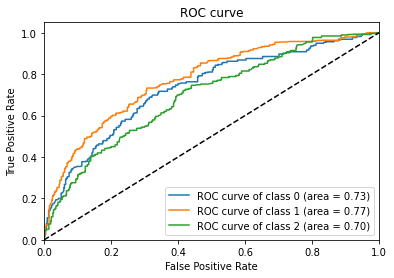

In [17]:
#Continent: 'Africa', 'Asia', 'Antarctica', 'Europe', 'North America', 'Oceania', 'South America' 
Africa_df = df_continent[df_continent['continent'] == 'Africa']
Africa_df = Africa_df.drop(columns=['country','continent'])
print(Africa_df.head())
print(Africa_df.shape)

movie = []
encode = []
n_genre = Africa_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,Africa_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = Africa_df.loc[Africa_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_Africa = np.array(movie)
encode_Africa = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_Africa = model.predict(movie_Africa)
predy_class_Africa = np.argmax(predy_Africa, axis=1)
truey_class_Africa = np.argmax(encode_Africa, axis=1)

performance_metrics(encode_Africa, predy_Africa)





         _Action  _Romance  _Thriller
1000002    False     False       True
1000009    False      True      False
1000032    False     False       True
1000086     True     False      False
1000139    False      True      False
(18192, 3)
188/188 ━━━━━━━━━━━━━━━━━━━━ 1458s 7s/step
Confusion Matrix: 
[[1355  322  323]
 [ 341 1430  229]
 [ 609  466  925]]
Accuracy: 0.6183333333333333
Precision: 0.6196156457220665
Recall: 0.6183333333333333
F1: 0.6132049742815963
AUC: 0.7985804080963135


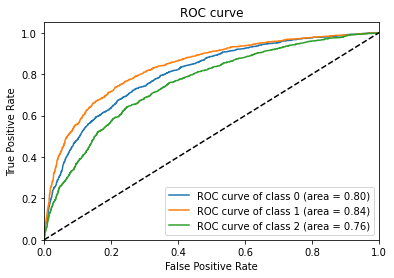

In [58]:
Asia_df = df_continent[df_continent['continent'] == 'Asia']
Asia_df = Asia_df.drop(columns=['country','continent'])
print(Asia_df.head())
print(Asia_df.shape)

movie = []
encode = []
n_genre = Asia_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,Asia_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = Asia_df.loc[Asia_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_Asia = np.array(movie)
encode_Asia = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_Asia = model.predict(movie_Asia)
predy_class_Asia = np.argmax(predy_Asia, axis=1)
truey_class_Asia = np.argmax(encode_Asia, axis=1)

performance_metrics(encode_Asia, predy_Asia)






In [59]:
#Antarctica has no corresponding movie poster

Antarctica_df = df_continent[df_continent['continent'] == 'Antarctica']
Antarctica_df = Antarctica_df.drop(columns=['country','continent'])
print(Antarctica_df.head())
print(Antarctica_df.shape)

movie = []
encode = []
n_genre = Antarctica_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,Antarctica_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = Antarctica_df.loc[Antarctica_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_Antarctica = np.array(movie)
encode_Antarctica = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_Antarctica = model.predict(movie_Antarctica)
predy_class_Antarctica = np.argmax(predy_Antarctica, axis=1)
truey_class_Antarctica = np.argmax(encode_Antarctica, axis=1)

performance_metrics(encode_Antarctica, predy_Antarctica)






Empty DataFrame
Columns: [_Action, _Romance, _Thriller]
Index: []
(0, 3)


ValueError: high <= 0

         _Action  _Romance  _Thriller
1000017     True     False      False
1000021    False     False       True
1000032    False     False       True
1000033    False     False       True
1000033    False     False       True
(16548, 3)
188/188 ━━━━━━━━━━━━━━━━━━━━ 1255s 6s/step
Confusion Matrix: 
[[1052  324  624]
 [ 265 1261  474]
 [ 315  381 1304]]
Accuracy: 0.6028333333333333
Precision: 0.6096308804702169
Recall: 0.6028333333333333
F1: 0.602552773994547
AUC: 0.7769778370857239


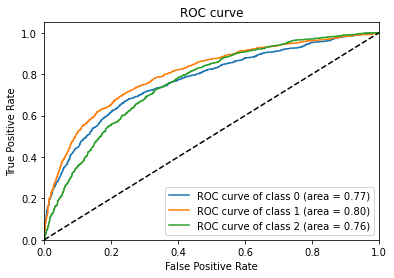

In [60]:
Europe_df = df_continent[df_continent['continent'] == 'Europe']
Europe_df = Europe_df.drop(columns=['country','continent'])
print(Europe_df.head())
print(Europe_df.shape)

movie = []
encode = []
n_genre = Europe_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,Europe_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = Europe_df.loc[Europe_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_Europe = np.array(movie)
encode_Europe = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_Europe = model.predict(movie_Europe)
predy_class_Europe = np.argmax(predy_Europe, axis=1)
truey_class_Europe = np.argmax(encode_Europe, axis=1)

performance_metrics(encode_Europe, predy_Europe)






         _Action  _Romance  _Thriller
1000003     True     False      False
1000006    False     False       True
1000006    False     False       True
1000007     True     False      False
1000009    False      True      False
(19553, 3)
188/188 ━━━━━━━━━━━━━━━━━━━━ 1321s 7s/step
Confusion Matrix: 
[[1170  278  552]
 [ 213 1383  404]
 [ 389  279 1332]]
Accuracy: 0.6475
Precision: 0.6517751034890501
Recall: 0.6475
F1: 0.6478865550002704
AUC: 0.8128871321678162


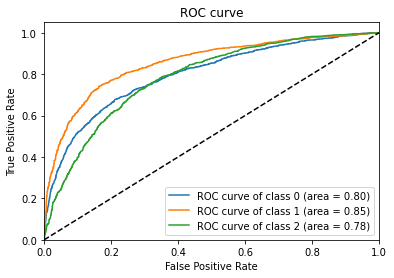

In [61]:
North_America_df = df_continent[df_continent['continent'] == 'North America']
North_America_df = North_America_df.drop(columns=['country','continent'])
print(North_America_df.head())
print(North_America_df.shape)

movie = []
encode = []
n_genre = North_America_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,North_America_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = North_America_df.loc[North_America_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_North_America = np.array(movie)
encode_North_America = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_North_America = model.predict(movie_North_America)
predy_class_North_America = np.argmax(predy_North_America, axis=1)
truey_class_North_America = np.argmax(encode_North_America, axis=1)

performance_metrics(encode_North_America, predy_North_America)






         _Action  _Romance  _Thriller
1000052    False      True      False
1000073    False     False       True
1001300    False     False       True
1001526    False     False       True
1001555    False     False       True
(2285, 3)
188/188 ━━━━━━━━━━━━━━━━━━━━ 1282s 7s/step
Confusion Matrix: 
[[ 996  457  547]
 [ 265 1209  526]
 [ 338  405 1257]]
Accuracy: 0.577
Precision: 0.5820500793341632
Recall: 0.577
F1: 0.5760149334323147
AUC: 0.7543856501579285


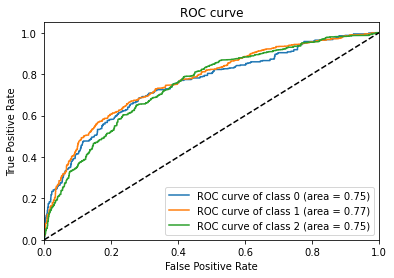

In [62]:
South_America_df = df_continent[df_continent['continent'] == 'South America']
South_America_df = South_America_df.drop(columns=['country','continent'])
print(South_America_df.head())
print(South_America_df.shape)

movie = []
encode = []
n_genre = South_America_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,South_America_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = South_America_df.loc[South_America_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_South_America = np.array(movie)
encode_South_America = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_South_America = model.predict(movie_South_America)
predy_class_South_America = np.argmax(predy_South_America, axis=1)
truey_class_South_America = np.argmax(encode_South_America, axis=1)

performance_metrics(encode_South_America, predy_South_America)






         _Action  _Romance  _Thriller
1000066     True     False      False
1000089     True     False      False
1000132     True     False      False
1000150     True     False      False
1000198    False     False       True
(992, 3)
93/93 ━━━━━━━━━━━━━━━━━━━━ 712s 8s/step
Confusion Matrix: 
[[498 169 325]
 [132 593 267]
 [163 156 673]]
Accuracy: 0.592741935483871
Precision: 0.6019934216837212
Recall: 0.592741935483871
F1: 0.5917641534387383
AUC: 0.759197473526001


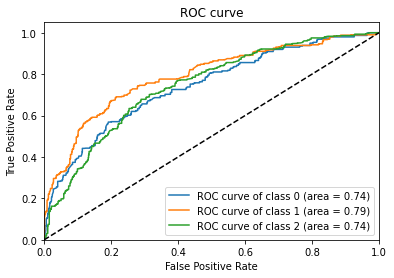

In [65]:
Oceania_df = df_continent[df_continent['continent'] == 'Oceania']
Oceania_df = Oceania_df.drop(columns=['country','continent'])
print(Oceania_df.head())
print(Oceania_df.shape)

movie = []
encode = []
n_genre = Oceania_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,Oceania_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = Oceania_df.loc[Oceania_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_Oceania = np.array(movie)
encode_Oceania = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_Oceania = model.predict(movie_Oceania)
predy_class_Oceania = np.argmax(predy_Oceania, axis=1)
truey_class_Oceania = np.argmax(encode_Oceania, axis=1)

performance_metrics(encode_Oceania, predy_Oceania)






In [7]:
#language
language = pd.read_csv('data/languages.csv', index_col=0)
df_language = encoded_filtered.merge(language, left_index=True, right_index=True)
df_language = df_language[df_language['type'].isin(['Primary language', 'Language'])]
print(df_language.head())
df_language.to_csv('language.csv', index=True)

import plotly.express as px

# Calculate the proportion of each language
language_proportion = df_language['language'].value_counts(normalize=True)

# Create a DataFrame from the series
df_language_proportion = pd.DataFrame({'language':language_proportion.index, 'proportion':language_proportion.values})

# Replace the languages with proportion lower than 0.02 with 'Others'
df_language_proportion.loc[df_language_proportion['proportion'] < 0.009, 'language'] = 'Others'

# Group by the new labels and sum the proportions
df_language_proportion = df_language_proportion.groupby('language').sum().reset_index()

# Create a pie chart
fig = px.pie(df_language_proportion, values='proportion', names='language', title='Distribution of Language')

# Remove the percentages from the labels and orient text radially
fig.update_traces(textinfo='label', insidetextorientation='radial')

# Display the pie chart
fig.show()












         _Action  _Romance  _Thriller              type language
1000002    False     False       True  Primary language   Korean
1000003     True     False      False  Primary language  English
1000006    False     False       True          Language  English
1000007     True     False      False  Primary language  English
1000009    False      True      False          Language  English


         _Action  _Romance  _Thriller
1000272    False      True      False
1002005     True     False      False
1002748     True     False      False
1003037     True     False      False
1004514     True     False      False
55/55 ━━━━━━━━━━━━━━━━━━━━ 366s 7s/step
Confusion Matrix: 
[[411  87  88]
 [106 419  61]
 [171 154 261]]
Accuracy: 0.6205915813424346
Precision: 0.6229391905441254
Recall: 0.6205915813424346
F1: 0.6139534944675248
AUC: 0.8111657500267029


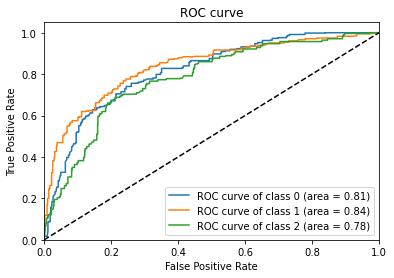

In [13]:
#Cantonese

Canto_df = df_language[df_language['language'] == 'Cantonese']
Canto_df = Canto_df.drop(columns=['type','language'])
print(Canto_df.head())
print(Canto_df.shape)

movie = []
encode = []
n_genre = Canto_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,Canto_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = Canto_df.loc[Canto_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_Canto = np.array(movie)
encode_Canto = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_Canto = model.predict(movie_Canto)
predy_class_Canto = np.argmax(predy_Canto, axis=1)
truey_class_Canto = np.argmax(encode_Canto, axis=1)

performance_metrics(encode_Canto, predy_Canto)



         _Action  _Romance  _Thriller
1000590    False     False       True
1000878    False      True      False
1000885    False     False       True
1001300    False     False       True
1001418    False     False       True
(3337, 3)
188/188 ━━━━━━━━━━━━━━━━━━━━ 1100s 6s/step
Confusion Matrix: 
[[1193  352  455]
 [ 229 1249  522]
 [ 326  393 1281]]
Accuracy: 0.6205
Precision: 0.6253965418743274
Recall: 0.6204999999999999
F1: 0.6212450939716563
AUC: 0.790274441242218


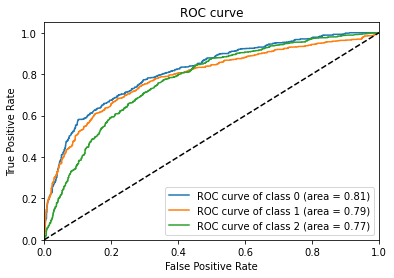

In [15]:
#Spanish

Spanish_df = df_language[df_language['language'] == 'Spanish']
Spanish_df = Spanish_df.drop(columns=['type','language'])
print(Spanish_df.head())
print(Spanish_df.shape)

movie = []
encode = []
n_genre = Spanish_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,Spanish_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = Spanish_df.loc[Spanish_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_Spanish = np.array(movie)
encode_Spanish = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_Spanish = model.predict(movie_Spanish)
predy_class_Spanish = np.argmax(predy_Spanish, axis=1)
truey_class_Spanish = np.argmax(encode_Spanish, axis=1)

performance_metrics(encode_Spanish, predy_Spanish)




         _Action  _Romance  _Thriller
1000002    False     False       True
1000371    False     False       True
1000378     True     False      False
1000679    False     False       True
1001063    False     False       True
(2777, 3)
188/188 ━━━━━━━━━━━━━━━━━━━━ 1140s 6s/step
Confusion Matrix: 
[[1122  360  518]
 [ 102 1635  263]
 [ 419  366 1215]]
Accuracy: 0.662
Precision: 0.661372583623
Recall: 0.662
F1: 0.6579706577629109
AUC: 0.8269596099853516


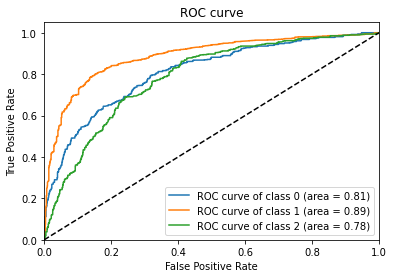

In [14]:
#Korean

Korean_df = df_language[df_language['language'] == 'Korean']
Korean_df = Korean_df.drop(columns=['type','language'])
print(Korean_df.head())
print(Korean_df.shape)

movie = []
encode = []
n_genre = Korean_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,Korean_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = Korean_df.loc[Korean_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_Korean = np.array(movie)
encode_Korean = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_Korean = model.predict(movie_Korean)
predy_class_Korean = np.argmax(predy_Korean, axis=1)
truey_class_Korean = np.argmax(encode_Korean, axis=1)

performance_metrics(encode_Korean, predy_Korean)




         _Action  _Romance  _Thriller
1000003     True     False      False
1000006    False     False       True
1000007     True     False      False
1000009    False      True      False
1000011    False     False       True
(28357, 3)
188/188 ━━━━━━━━━━━━━━━━━━━━ 1103s 6s/step
Confusion Matrix: 
[[1113  313  574]
 [ 245 1288  467]
 [ 379  335 1286]]
Accuracy: 0.6145
Precision: 0.6195640249840456
Recall: 0.6144999999999999
F1: 0.6148479090521741
AUC: 0.7826557159423828


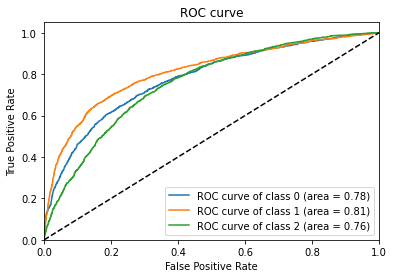

In [16]:
#English

English_df = df_language[df_language['language'] == 'English']
English_df = English_df.drop(columns=['type','language'])
print(English_df.head())
print(English_df.shape)

movie = []
encode = []
n_genre = English_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,English_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = English_df.loc[English_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_English = np.array(movie)
encode_English = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_English = model.predict(movie_English)
predy_class_English = np.argmax(predy_English, axis=1)
truey_class_English = np.argmax(encode_English, axis=1)

performance_metrics(encode_English, predy_English)




         _Action  _Romance  _Thriller
1000255    False      True      False
1000517     True     False      False
1000532    False     False       True
1000745    False     False       True
1001148    False     False       True
(3292, 3)
188/188 ━━━━━━━━━━━━━━━━━━━━ 1349s 7s/step
Confusion Matrix: 
[[1474  334  192]
 [ 328 1497  175]
 [ 650  597  753]]
Accuracy: 0.6206666666666667
Precision: 0.630006730144482
Recall: 0.6206666666666667
F1: 0.6070061242978868
AUC: 0.8115738034248352


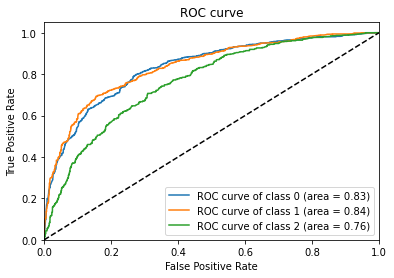

In [63]:
#Japanese

Japanese_df = df_language[df_language['language'] == 'Japanese']
Japanese_df = Japanese_df.drop(columns=['type','language'])
print(Japanese_df.head())
print(Japanese_df.shape)

movie = []
encode = []
n_genre = Japanese_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,Japanese_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = Japanese_df.loc[Japanese_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_Japanese = np.array(movie)
encode_Japanese = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_Japanese = model.predict(movie_Japanese)
predy_class_Japanese = np.argmax(predy_Japanese, axis=1)
truey_class_Japanese = np.argmax(encode_Japanese, axis=1)

performance_metrics(encode_Japanese, predy_Japanese)





         _Action  _Romance  _Thriller
1001555    False     False       True
1002605    False      True      False
1003155     True     False      False
1004978     True     False      False
1005831    False     False       True
(1326, 3)
125/125 ━━━━━━━━━━━━━━━━━━━━ 874s 7s/step
Confusion Matrix: 
[[596 316 414]
 [180 754 392]
 [162 219 945]]
Accuracy: 0.5769230769230769
Precision: 0.5866785447999611
Recall: 0.576923076923077
F1: 0.5724698170237709
AUC: 0.7578275203704834


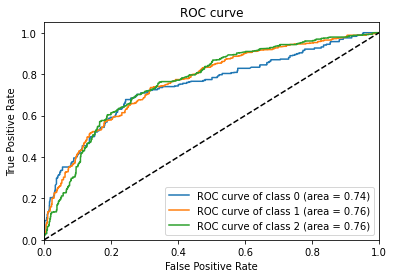

In [64]:
#Portuguese

Portuguese_df = df_language[df_language['language'] == 'Portuguese']
Portuguese_df = Portuguese_df.drop(columns=['type','language'])
print(Portuguese_df.head())
print(Portuguese_df.shape)

movie = []
encode = []
n_genre = Portuguese_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,Portuguese_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = Portuguese_df.loc[Portuguese_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_Portuguese = np.array(movie)
encode_Portuguese = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_Portuguese = model.predict(movie_Portuguese)
predy_class_Portuguese = np.argmax(predy_Portuguese, axis=1)
truey_class_Portuguese = np.argmax(encode_Portuguese, axis=1)

performance_metrics(encode_Portuguese, predy_Portuguese)





         _Action  _Romance  _Thriller
1003403    False     False       True
1003754    False      True      False
1004043    False     False       True
1004462    False     False       True
1005314    False      True      False
(671, 3)
63/63 ━━━━━━━━━━━━━━━━━━━━ 385s 6s/step
Confusion Matrix: 
[[448 115 108]
 [145 452  74]
 [183 144 344]]
Accuracy: 0.6179831097863885
Precision: 0.6223454383309973
Recall: 0.6179831097863885
F1: 0.6160356264616983
AUC: 0.823080837726593


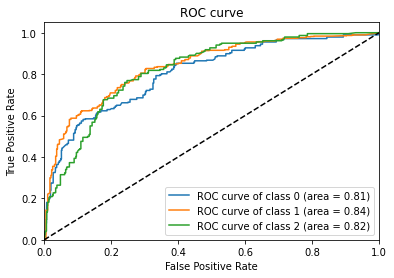

In [66]:
#Thai

Thai_df = df_language[df_language['language'] == 'Thai']
Thai_df = Thai_df.drop(columns=['type','language'])
print(Thai_df.head())
print(Thai_df.shape)

movie = []
encode = []
n_genre = Thai_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,Thai_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = Thai_df.loc[Thai_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_Thai = np.array(movie)
encode_Thai = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_Thai = model.predict(movie_Thai)
predy_class_Thai = np.argmax(predy_Thai, axis=1)
truey_class_Thai = np.argmax(encode_Thai, axis=1)

performance_metrics(encode_Thai, predy_Thai)






         _Action  _Romance  _Thriller
1004737    False      True      False
1004957     True     False      False
1005288    False     False       True
1006031    False     False       True
1006449    False      True      False
(1345, 3)
127/127 ━━━━━━━━━━━━━━━━━━━━ 896s 7s/step
Confusion Matrix: 
[[789 290 266]
 [274 884 187]
 [413 295 637]]
Accuracy: 0.5724907063197026
Precision: 0.5735754755858836
Recall: 0.5724907063197026
F1: 0.5702888429779904
AUC: 0.762713611125946


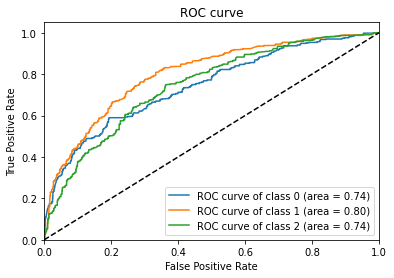

In [8]:
#Hindi

Hindi_df = df_language[df_language['language'] == 'Hindi']
Hindi_df = Hindi_df.drop(columns=['type','language'])
print(Hindi_df.head())
print(Hindi_df.shape)

movie = []
encode = []
n_genre = Hindi_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,Hindi_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = Hindi_df.loc[Hindi_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_Hindi = np.array(movie)
encode_Hindi = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_Hindi = model.predict(movie_Hindi)
predy_class_Hindi = np.argmax(predy_Hindi, axis=1)
truey_class_Hindi = np.argmax(encode_Hindi, axis=1)

performance_metrics(encode_Hindi, predy_Hindi)




